#**Movie Recommendation System using Collaborative Filtering**

This filtration strategy is based on the combination of the user’s behavior and comparing and contrasting that with other users’ behavior in the database

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import zipfile
from google.colab import drive
import os

**Loading Dataset**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

978202/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done!


**Preprocessing the dataset**

encode users and movies as integer indices.

In [4]:
# df = ratings
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


**Prepare training and validation data**

In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

**Create the model**

The model uses embeddings to represent users and movies as dense vectors of a fixed size.
The model takes as input a tensor of shape (batch_size, 2), where each row represents a user-movie pair.
The dot product of the user and movie embeddings is computed and added to the user and movie biases, and the result is passed through a sigmoid activation function to produce a predicted rating between 0 and 1.

In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

**Training the Model**

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
709/709 [==============================] - 16s 16ms/step - loss: 0.6417 - val_loss: 0.6242
Epoch 2/5
709/709 [==============================] - 3s 4ms/step - loss: 0.6186 - val_loss: 0.6378
Epoch 3/5
709/709 [==============================] - 3s 5ms/step - loss: 0.6116 - val_loss: 0.6234
Epoch 4/5
709/709 [==============================] - 3s 4ms/step - loss: 0.6100 - val_loss: 0.6233
Epoch 5/5
709/709 [==============================] - 2s 3ms/step - loss: 0.6108 - val_loss: 0.6181


In [8]:
base_path="/content/drive/MyDrive"
model.save_weights(os.path.sep.join([base_path,'movielenssmalllatest_weights.h5']))

In [9]:
tf.saved_model.save(model, os.path.sep.join([base_path,'movielenssmalllatest_weights_savemodel']))

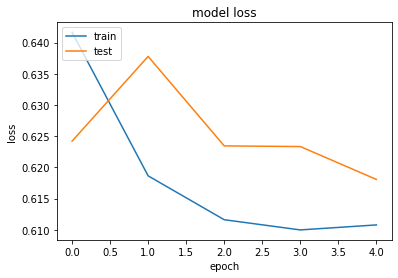

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**Predicting users recommended movies**

In [11]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))

print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

292/292 [==============================] - 1s 3ms/step
Showing recommendations for user: 567
Top 10 movie recommendations
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Schindler's List (1993) : Drama|War
Godfather, The (1972) : Crime|Drama
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Matrix, The (1999) : Action|Sci-Fi|Thriller
Fight Club (1999) : Action|Crime|Drama|Thriller


**Storing the recommendations for all in a csv file**

In [12]:
# Get the first 10 unique user IDs from the ratings dataframe
movie_df = pd.read_csv(movielens_dir / "movies.csv")

user_ids = df.userId.unique()[:5000]

# Create a dictionary to store recommendations for each user
user_recommendations = {}

# Iterate over each user and get their top recommendations
for user_id in user_ids:
    movies_watched_by_user = df[df.userId == user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    recommended_movie_titles = [
        movie_df.loc[movie_df['movieId']==int(movie_id), 'title'].iloc[0]
        for movie_id in recommended_movie_ids
    ]
    user_recommendations[user_id] = recommended_movie_titles

# Convert the dictionary to a pandas dataframe and save as a CSV file
recommendations_df = pd.DataFrame.from_dict(user_recommendations, orient='index')
recommendations_df.index.name = 'userId'
recommendations_df.columns = [f"recommendation_{i+1}" for i in range(10)]
recommendations_df.to_csv('user_recommendations.csv')

303/303 [==============================] - 1s 2ms/step
